# 합성곱 신경망 다중분류 전이학습 (transfer learning)(cifar10 컬러 이미지)  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

## 1.데이터 준비

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [4]:
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [5]:
y_train.shape, y_test.shape

((50000,), (10000,))

In [6]:
pd.Series(y_train).value_counts()

,count
6,5000
9,5000
4,5000
1,5000
2,5000
7,5000
8,5000
3,5000
5,5000
0,5000


In [7]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [8]:
samples = np.random.randint(50000, size=25)
samples

array([33817, 28382, 11452,  8666, 16637, 39530, 34844,  7230, 20477,
       25832, 35927, 24942, 24599, 13764, 33428, 33554,  8820, 16584,
        6280, 12970, 13682, 20079, 42427, 40222, 16401])

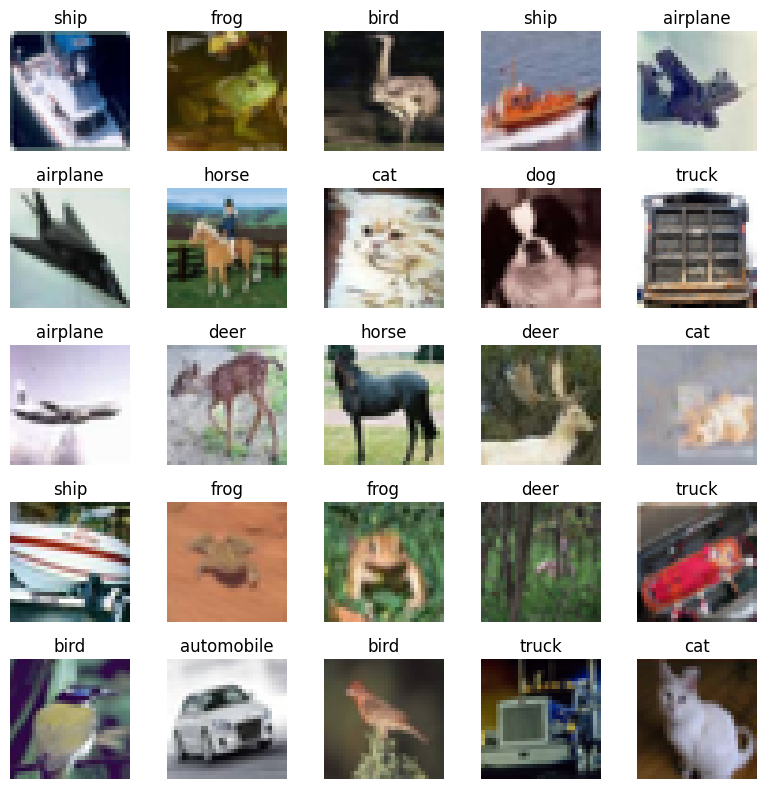

In [9]:
fig = plt.figure(figsize=(8, 8))

for i, idx in enumerate(samples):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.axis('off')
    plt.title(classes[y_train[idx]])
plt.tight_layout()
plt.show()

## 2.데이터 분리

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [12]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (40000,), (10000,))

### 스케일링

In [13]:
X_train_s = X_train.astype('float32')/255
X_val_s = X_val.astype('float32')/255
X_test_s = X_test.astype('float32')/255

### 원핫인코딩

In [14]:
from keras.utils import to_categorical

In [15]:
y_train_o = to_categorical(y_train)
y_val_o = to_categorical(y_val)

In [16]:
y_train_o[:5]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

## 5.모델 만들기

In [17]:
from keras.applications import VGG16

In [18]:
base_model = VGG16(
    input_shape=(32, 32, 3),
    weights='imagenet',
    include_top=False
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [20]:
from keras import layers

In [21]:
model = keras.models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(units=256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(units=32, activation='relu'),
    layers.Dense(units=10, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,854,570 (56.67 MB)

 Trainable params: 139,882 (546.41 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [22]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

In [23]:
# early stopping 롤백함수 설정
from keras.callbacks import EarlyStopping

In [24]:
es = EarlyStopping(
    monitor='val_loss',
    patience=5,
)

In [25]:
EPOCHS = 3
BATCH_SIZE = 32

In [26]:
history = model.fit(
    X_train_s,
    y_train_o,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_s, y_val_o),
    callbacks=[es]
)

Epoch 1/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - acc: 0.4474 - loss: 1.5689 - val_acc: 0.5499 - val_loss: 1.2632
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - acc: 0.5760 - loss: 1.2110 - val_acc: 0.5891 - val_loss: 1.1829
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - acc: 0.6026 - loss: 1.1366 - val_acc: 0.5930 - val_loss: 1.1569


### 학습 그래프

In [27]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'], label='train_loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='val_loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['acc'], label='train_acc')
    plt.plot(hist['epoch'], hist['val_acc'], label='val_acc')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

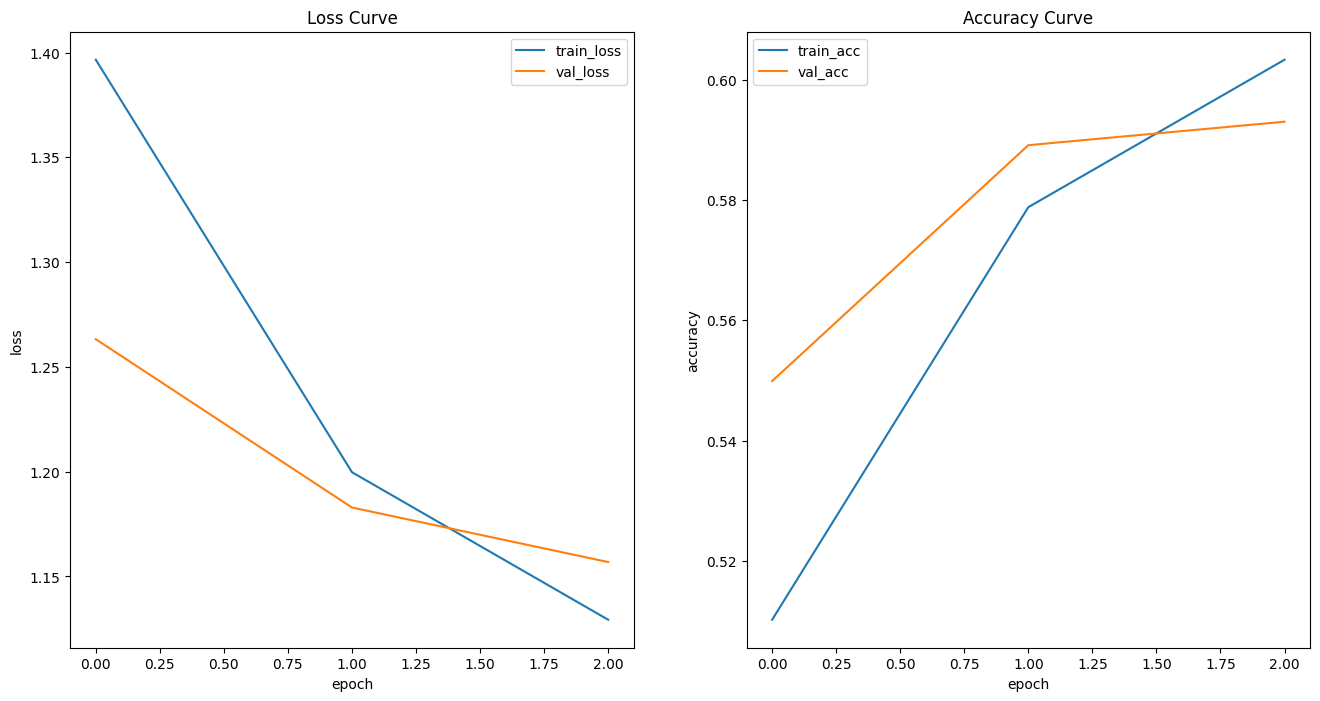

In [28]:
plot_history(history)

## 6.테스트

In [29]:
X_test_s.shape

(10000, 32, 32, 3)

In [30]:
y_pred = model.predict(X_test_s)
y_pred

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


array([[2.3117026e-02, 1.0531706e-01, 1.4858156e-02, ..., 1.9482756e-02,
        1.1487478e-02, 7.6610088e-02],
       [3.5681177e-02, 1.0939081e-01, 2.4448349e-03, ..., 1.9664117e-04,
        8.3526683e-01, 1.4193780e-02],
       [9.1546401e-02, 6.2137283e-02, 3.5247558e-03, ..., 2.4875460e-02,
        6.0024172e-01, 1.2024026e-01],
       ...,
       [3.6394634e-04, 3.8299751e-03, 4.2964291e-02, ..., 3.3686750e-02,
        3.4447349e-04, 2.2113929e-03],
       [1.7347071e-01, 2.0244528e-02, 1.4543821e-01, ..., 1.3362700e-01,
        5.6597437e-03, 2.6212260e-02],
       [4.9460959e-03, 1.9174310e-03, 1.9060917e-03, ..., 9.1074240e-01,
        3.3604802e-04, 2.1543875e-02]], dtype=float32)

In [31]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([3, 8, 8, ..., 5, 5, 7])

In [32]:
y_test

array([3, 8, 8, ..., 5, 1, 7], dtype=uint8)

## 5.평가지표

In [33]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

In [34]:
def print_metrics(y_true, y_pred):
  acc = accuracy_score(y_true, y_pred)
  re = recall_score(y_true, y_pred,average='macro')
  pre = precision_score(y_true, y_pred,average='macro')
  f1 = f1_score(y_true, y_pred,average='macro')

  print('acc: ', acc)
  print('recall: ', np.around(re, 4))
  print('precision: ', np.around(pre, 4))
  print('f1: ', np.around(f1, 4))

  cfm = confusion_matrix(y_true, y_pred)
  s = sns.heatmap(cfm, annot=True, cmap='Blues', fmt='d', cbar=False)
  s.set(xlabel='Prediction', ylabel='Actual')
  plt.show()

acc:  0.5897
recall:  0.5897
precision:  0.5968
f1:  0.5864


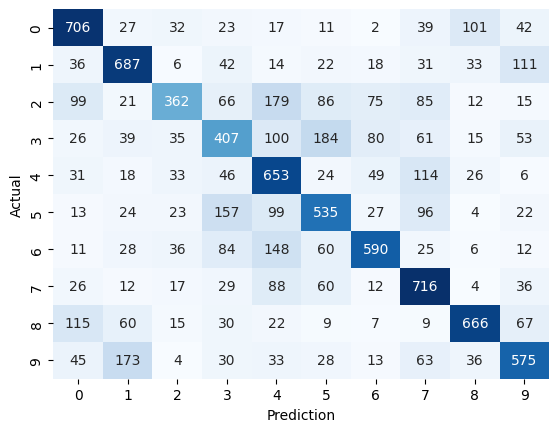

In [35]:
print_metrics(y_test, y_pred)

### 7.모델 저장

In [37]:
model.save('cnn_multi_transfer_90.keras')

In [38]:
loaded_model = keras.models.load_model('cnn_multi_transfer_90.keras')
loaded_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,994,454 (57.20 MB)

 Trainable params: 139,882 (546.41 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 139,884 (546.43 KB)

In [ ]:
tf.saved_model.save(model, 'my_model')